In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
from Data import get_setup
import os
from datetime import datetime
import timeit

import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import trange
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler
import argparse


In [3]:
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
## large ##
# predictive model architecture
layerwidth = 100
nblayers = 1
activation = nn.ReLU()



In [5]:
path="Results/Paper/Exp2/Exp2_large2021-01-29-00:41"

In [6]:
MODELS=torch.load(path+"_models.pt",map_location=device)


In [7]:
datasets = ['navalC', 'powerplant', 'protein']
# for key in MODELS.keys():
#     datasets.append(key)

methods=['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
# for key in MODELS[datasets[0]][0][1].keys():
#     methods.append(key)
    
datasets, methods

(['navalC', 'powerplant', 'protein'],
 ['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI'])

# Results on Test

In [8]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [9]:
results=[]

#torch.cat([model(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=0)
for dataset in datasets:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']

        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test)
        metrics = get_metrics(y_pred, torch.tensor(0.), y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model.predict(x_test, 1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
            
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        #Results.append({dataset:split_results})

In [9]:
results=[]

#torch.cat([model(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=0)
for dataset in ['navalC']:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']

  
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        print(model.sigma_noise)
    
        
   
        
    

tensor(0.0170, device='cuda:0', grad_fn=<LogBackward>)
tensor(0.0148, device='cuda:0', grad_fn=<LogBackward>)
tensor(0.0161, device='cuda:0', grad_fn=<LogBackward>)
tensor(0.0138, device='cuda:0', grad_fn=<LogBackward>)
tensor(0.0167, device='cuda:0', grad_fn=<LogBackward>)


In [34]:
torch.save(results,path+'_results.pt')

# RMSE

In [8]:
import pandas as pd
results=torch.load(path+'_results.pt')
df=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis_r')


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
navalC,0.000548,0.000439,0.000465,0.000528,0.000211,0.000208
powerplant,3.993160,3.976920,4.086950,4.152754,3.920737,3.886800
protein,4.310625,4.095686,4.241076,4.343346,4.159663,4.142557


In [9]:
for i in df_.columns:
    df_[i] = df_[i].round(6).astype(str)+ "±" + (df_sem_[i].round(6)).astype(str)+""

In [10]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &         MC dropout &           Ensemble &               MFVI &          FuNN-MFVI &            NN-HyVI &          FuNN-HyVI \\
dataset    &                    &                    &                    &                    &                    &                    \\
\midrule
navalC     &   0.000548±0.00012 &   0.000439±4.2e-05 &   0.000465±4.1e-05 &   0.000528±2.4e-05 &   0.000211±1.1e-05 &   0.000208±1.2e-05 \\
powerplant &   3.99316±0.048187 &   3.97692±0.061691 &   4.08695±0.041063 &  4.152754±0.055186 &  3.920737±0.054093 &    3.8868±0.064615 \\
protein    &  4.310625±0.021799 &  4.095686±0.023521 &  4.241076±0.025538 &   4.343346±0.02107 &  4.159663±0.028977 &  4.142557±0.028518 \\
\bottomrule
\end{tabular}



# LPP

In [45]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis')
#df_.style.highlight_max(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
navalC,5.918683,6.120915,6.270366,6.129230,7.032638,7.054615
powerplant,-15.864895,-63.117865,-2.827105,-2.845986,-2.786496,-2.778549
protein,-20.018803,-12.095848,-2.864320,-2.887883,-2.844585,-2.840966


In [46]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

print(df_.to_latex())

# displaying logs

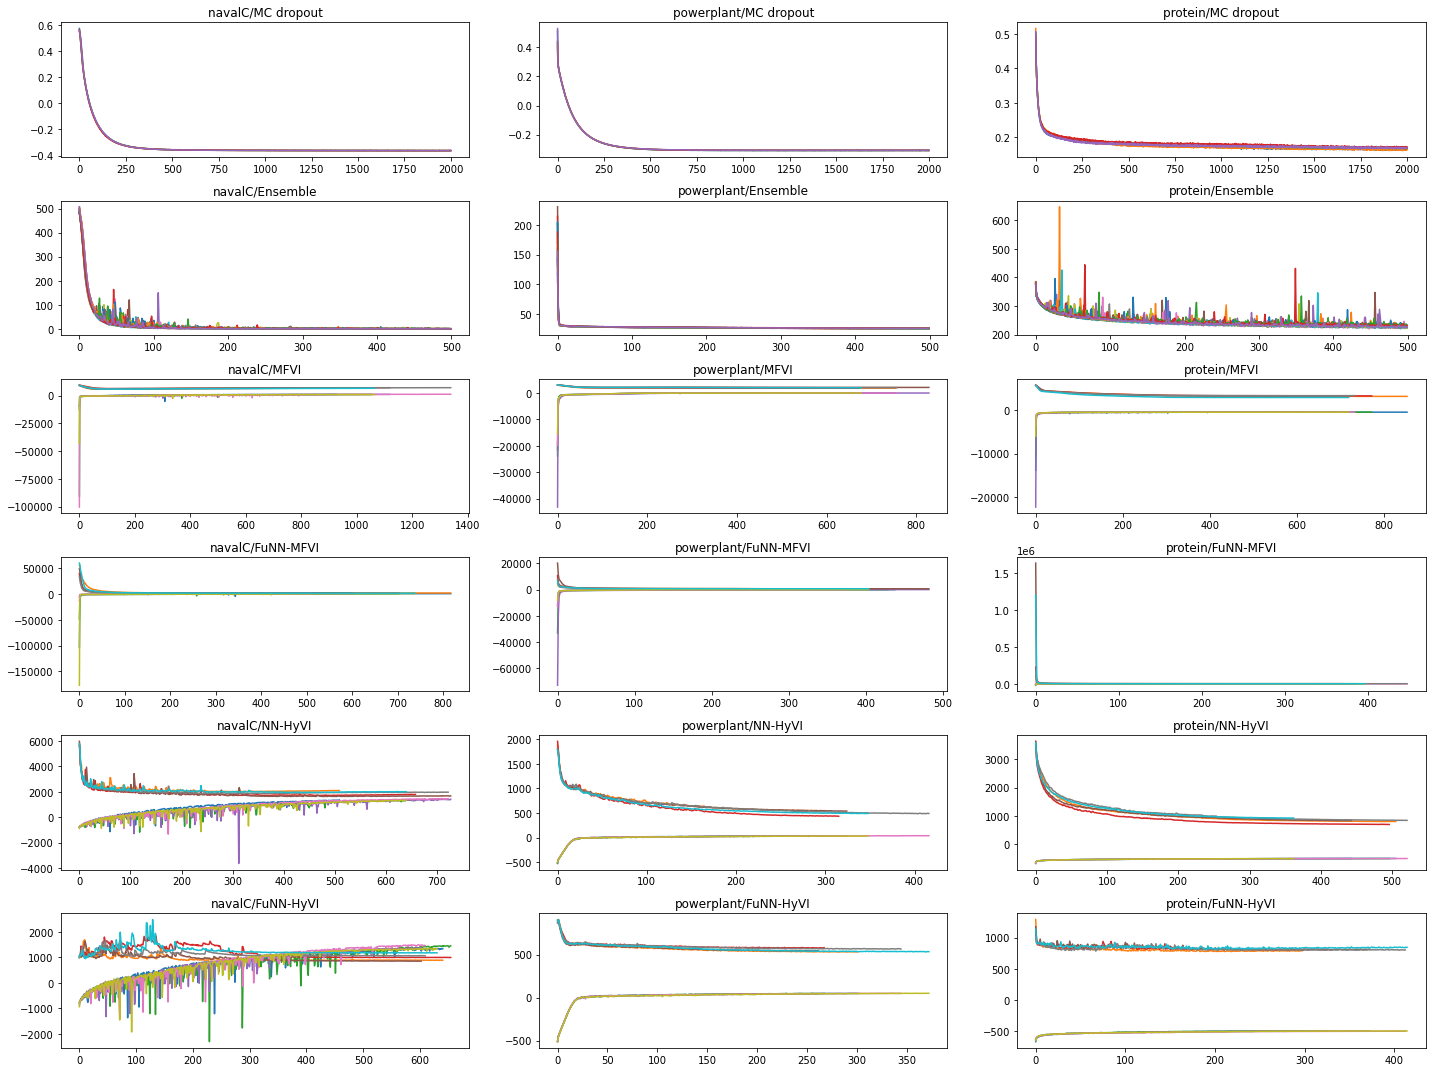

In [41]:
from pylab import *
fig, ax=plt.subplots(len(methods), len(datasets), figsize=(20,15))
ax=ax.flatten()
i=0
for method in methods:
    for dataset in datasets:
        for split in MODELS[dataset]: 
            logs=split[1][method][1]
            for key in logs.keys():
                if key=='KL' or key=='loss' or key=='LL' or isinstance(key, int): 
                    ax[i].plot(range(len(logs[key])), logs[key])
                #ax[i].legend()
                ax[i].set_title(dataset+'/'+method)
        i+=1

fig.tight_layout()

# OOD detection

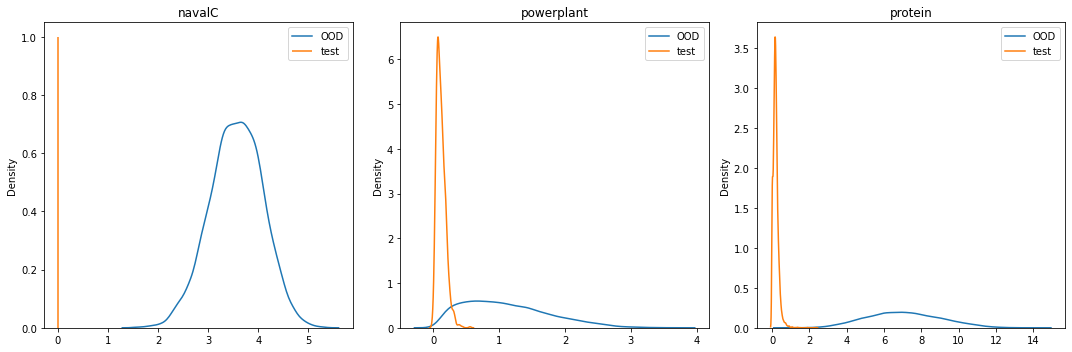

In [9]:
import seaborn as sns
from pylab import *
from torch.distributions import MultivariateNormal
from matplotlib.colors import ListedColormap

cmap=ListedColormap(sns.color_palette("tab10").as_hex())


def nn_dist(X):
    #X_in=torch.cat([X[0],X[1]])
    X_train=X[0]
    X_test=X[1]
    X_ood=X[2]
    dist_ood=torch.cdist(X_train,X_ood)
    dist_test=torch.cdist(X_train,X_test)
    #print(X_in.shape, X_ood.shape, dist.shape)
    return dist_test.min(dim=0)[0], dist_ood.min(dim=0)[0]

fig, ax=plt.subplots(1,3, figsize=(15,5))
ax=ax.flatten()
i=0
for dataset in datasets:
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=10000) #MultivariateNormal(x_train.mean(0), covariance_matrix=.5*torch.diag(x_train.std(0))) #
        x_OOD=OOD_sampler()#OOD_sampler.sample((50000,))
        
        X = [x_train, x_test, x_OOD]
        if split_nb==2:
            test, ood= nn_dist(X)
            sns.kdeplot(ood.cpu(), ax=ax[i], label='OOD')
            ax[i].set_title(dataset)
            if test.std() < 0.01:
                ax[i].vlines(x=test.mean(), ymin=0, ymax=1, color=cmap(1), label='test')
            else:
                sns.kdeplot(test.cpu(), ax=ax[i], label='test')
            ax[i].legend()
            i+=1
fig.tight_layout()

In [9]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

VARs={dataset:{method: [] for method in methods} for dataset in datasets}
#Hs=torch.load(path+'_epist_entropy_50k.pt')
#MODELS.to(device)
def VAR(model, X):
#    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]
    return [torch.cat([model(x_, 1000).detach().std(0).squeeze() for x_ in x.split(100,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)
n_ood=10000
    
for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_ood)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
        #Y=[model.predict(x, 1000) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        


navalC
0
1
2
3
4
powerplant
0
1
2
3
4
protein
0
1
2
3
4


In [10]:
torch.save(VARs,path+'_epist_VAR_10K.pt')

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=torch.load(path+'_epist_VAR_10K.pt')
roc_data={dataset:{} for dataset in datasets}
AUC={}#{dataset:{} for dataset in datsets}

n_ood=10000
fpr=torch.arange(n_ood).true_divide(n_ood)

for dataset in datasets:     
    for method in methods:
        AUCs=[]

        TPRs=[]
        for h in Hs[dataset][method]:
            H_in=torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            TPRs.append((H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in)))

            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))
        roc_data[dataset].update({method: {'AUC':np.mean(AUCs),'tpr_mean': torch.stack(TPRs).mean(0), 'tpr_min':torch.stack(TPRs).min(0)[0], 'tpr_max':torch.stack(TPRs).max(0)[0]}})

        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))

navalC/MC dropout: 0.9999906686777276
navalC/Ensemble: 0.9999999966482319
navalC/MFVI: 0.7434667521367521
navalC/FuNN-MFVI: 0.9979394209820681
navalC/NN-HyVI: 0.9999999966482319
navalC/FuNN-HyVI: 0.9999981263616557
powerplant/MC dropout: 0.9167045129598664
powerplant/Ensemble: 0.9317545150501674
powerplant/MFVI: 0.8763525637541806
powerplant/FuNN-MFVI: 0.9239810702341137
powerplant/NN-HyVI: 0.9622886799749164
powerplant/FuNN-HyVI: 0.9612789339464884
protein/MC dropout: 0.9998683695604635
protein/Ensemble: 0.9999066385305051
protein/MFVI: 0.9991650502952112
protein/FuNN-MFVI: 0.9959044907063197
protein/NN-HyVI: 0.9999871152416357
protein/FuNN-HyVI: 0.9998603608134704


In [10]:
torch.save(roc_data,path+'_roc_data_VAR10K.pt')
torch.save(AUC,path+'_AUC_VAR1K.pt')


In [11]:
roc_data=torch.load(path+'_roc_data_VAR10K.pt')
AUC=torch.load(path+'_AUC_VAR1K.pt')


<ipython-input-14-45d54bb64b36>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


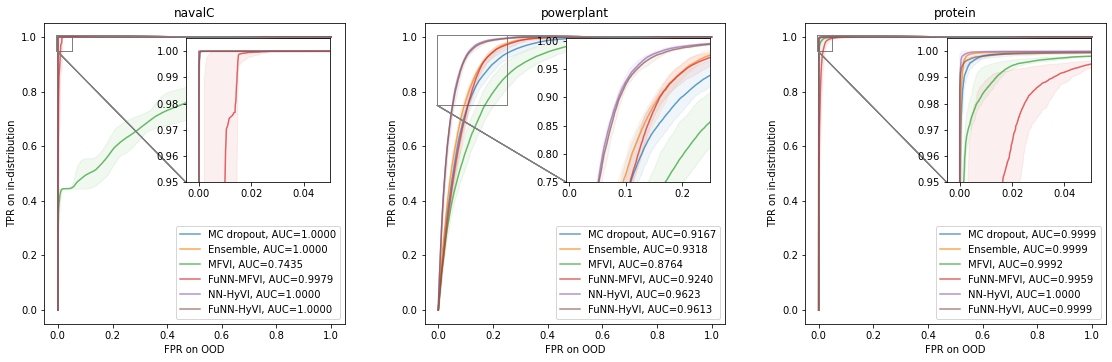

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.colors import ListedColormap

from pylab import *
import seaborn as sns
l=len(datasets)
fig, ax= plt.subplots(1,l,figsize=(5*l+1,5))
d=0
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
R=[0.05, 0.25, 0.05]
B=[0.95, 0.75, 0.95]
n_ood=10000
def add_zero(x):
    return torch.cat([torch.zeros(1,1),x.view(-1,1)]).squeeze()
fpr=add_zero(torch.arange(n_ood).true_divide(n_ood))
colors=[]
for dataset in datasets:
    c=0
    zoom_ax = inset_axes(ax[d], width=2, height=2,  loc='upper right',borderpad=1.5)      
    for method in methods:
        AUC=roc_data[dataset][method]['AUC']
        tpr_mean=add_zero(roc_data[dataset][method]['tpr_mean'])
        tpr_min=add_zero(roc_data[dataset][method]['tpr_min'])
        tpr_max=add_zero(roc_data[dataset][method]['tpr_max'])
        ax[d].plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        ax[d].fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))

        zoom_ax.plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        zoom_ax.fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))  
        mark_inset(ax[d], zoom_ax, loc1=1, loc2=3, fc="none", ec="0.5")

        c+=1
    zoom_ax.set_xlim(left=-0.005, right=R[d])
    zoom_ax.set_ylim(bottom=B[d], top=1.005)
    zoom_ax.legend().remove()
    zoom_ax.set_xlabel('')
    zoom_ax.set_ylabel('')
    zoom_ax.set_aspect('equal')
    ax[d].legend()
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_xlim(left=-0.05, right=1.05)
    ax[d].set_ylim(bottom=-.05, top=1.05)
    ax[d].set_aspect('equal')

    d+=1


fig.tight_layout()
plt.savefig(path+"_ROC_curves.pdf", dpi=600)


<ipython-input-13-4fe06c9979ad>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


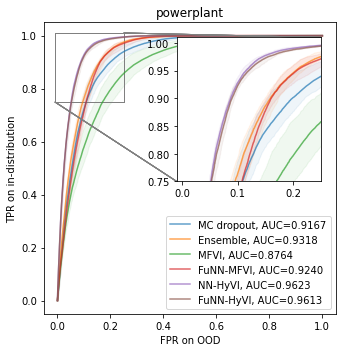

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.colors import ListedColormap

from pylab import *
import seaborn as sns
l=1
fig, ax= plt.subplots(1,l,figsize=(5*l,5))

cmap=ListedColormap(sns.color_palette("tab10").as_hex())
R=[0.25]
B=[ 0.75]
ax=[ax]
def add_zero(x):
    return torch.cat([torch.zeros(1,1),x.view(-1,1)]).squeeze()
fpr=add_zero(torch.arange(n_ood).true_divide(n_ood))
d=0
for dataset in ['powerplant']:
    c=0

    zoom_ax = inset_axes(ax[d], width=2, height=2,  loc='upper right',borderpad=1.5)      
    for method in methods:
        AUC=roc_data[dataset][method]['AUC']
        tpr_mean=add_zero(roc_data[dataset][method]['tpr_mean'])
        tpr_min=add_zero(roc_data[dataset][method]['tpr_min'])
        tpr_max=add_zero(roc_data[dataset][method]['tpr_max'])
        ax[d].plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        ax[d].fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))

        zoom_ax.plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        zoom_ax.fill_between(fpr, tpr_min, tpr_max, alpha=0.07, color=cmap(c))  
        mark_inset(ax[d], zoom_ax, loc1=1, loc2=3, fc="none", ec="0.5")

        c+=1
    zoom_ax.set_xlim(left=-0.01, right=R[d])
    zoom_ax.set_ylim(bottom=B[d], top=1.01)
    zoom_ax.legend().remove()
    zoom_ax.set_xlabel('')
    zoom_ax.set_ylabel('')
    zoom_ax.set_aspect('equal')
    ax[d].legend()
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_xlim(left=-0.05, right=1.05)
    ax[d].set_ylim(bottom=-.05, top=1.05)
    ax[d].set_aspect('equal')

    d+=1


fig.tight_layout()
plt.savefig(path+"_ROC_curves_powerplant.pdf", dpi=600)


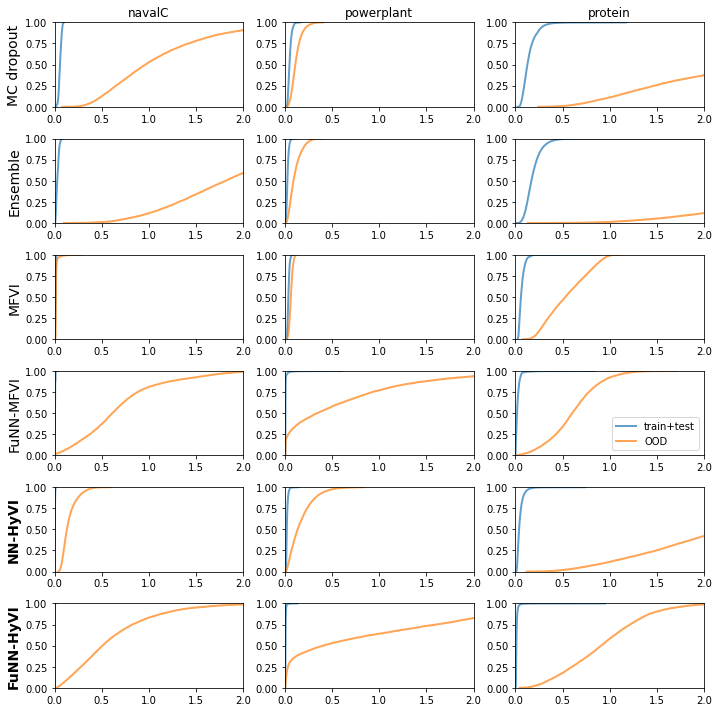

In [46]:
from pylab import *
import seaborn as sns
import pandas as pd

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=VARs
n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(10,10),squeeze=False)

data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in datasets:
    m=0
    ax[m,d].set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        for i in range(len(H)):
            #sns.histplot(H[i].cpu(), stat='density', element='step', alpha = .7, kde=True, color=cmap(i), label=data_type[i],ax=ax[m,d])#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m,d],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if (m,d) == (3,2): 
            ax[m,d].legend()#.remove()
        ax[m,d].set_xlim(left=0, right=2)
        ax[m,d].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarECDF_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

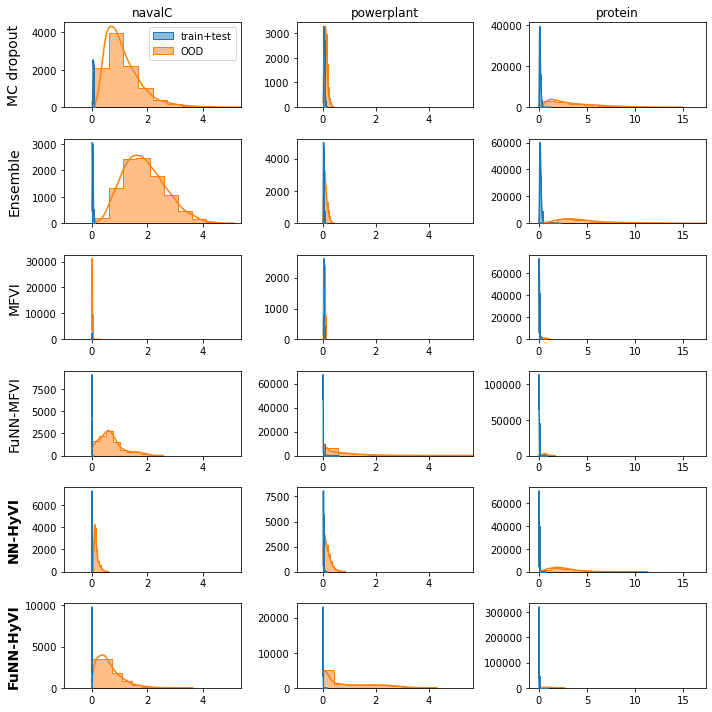

In [44]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=VARs
n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(10,10),squeeze=False)

data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in datasets:
    m=0
    max_var=[]
    ax[m,d].set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]

        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            sns.histplot(H[i].cpu(), stat='count', bins=10, element='step', alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m,d], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            #sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m,d],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if (m,d) == (0,0): 
            ax[m,d].legend()#.remove()
        ax[m,d].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1
    for m in range(n_methods):
        ax[m,d].set_xlim(left=-1, right=np.max(max_var))

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarDist_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

MC dropout
Ensemble
MFVI
FuNN-MFVI
NN-HyVI
FuNN-HyVI


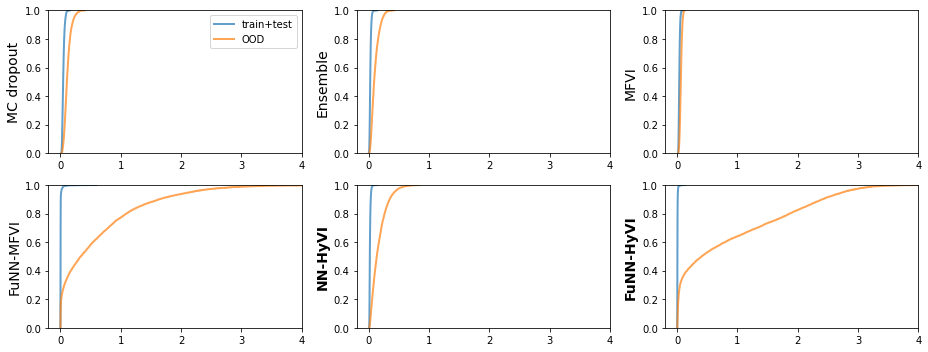

In [51]:
from pylab import *
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=VARs
n_methods=len(methods)
fig,ax=plt.subplots(2,3,figsize=(13,5),squeeze=True)
ax=ax.flatten()
data_type=['train+test', 'OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

split=1
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
d=0
for dataset in ['powerplant']:
    m=0
    max_var=[]
    #ax.set_title(dataset)
    for method in methods:
        H_=Hs[dataset][method][split]
        H=[torch.cat([H_[0],H_[1]]), H_[2]]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        print(method)
        
        for i in range(len(H)):
            max_var.append(H[i].max().cpu())
            #sns.histplot(H[i].cpu(), stat='density', bins=10, element='step', alpha = .5, kde=True, color=cmap(i), label=data_type[i],ax=ax[m], zorder=3-i)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],

        if m==0: 
            ax[m].legend()#.remove()
        ax[m].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m].set_ylabel(method)
        m+=1
    for m in range(n_methods):
        ax[m].set_xlim(left=-.2, right=4)
        #ax[m].set_ylim(bottom=0., top=1.1)


    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
#fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_EpistVarECDF_Exp2-{}.pdf".format(dataset), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

# Entropy parametric vs predictor


In [52]:
from Metrics import entropy_nne
def FunH(model, sampler, n=100, n_MC=200):
    Hs=[entropy_nne(model(sampler()).squeeze(2), k=1, k_MC=n_MC).item() for _ in range(n)]
    return np.mean(Hs)



In [71]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

Hs={dataset:{} for dataset in datasets}

def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)

nb_predictors=1000    
n_MC=200
    
for dataset in datasets:
    print(dataset)
    split_nb=0
    Hs[dataset].update({(method,'parameter'):[] for method in methods})
    Hs[dataset].update({(method,'predictor'):[] for method in methods})

    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_MC)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.get_parameters, k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(model, OOD_sampler, n=100, n_MC=200))

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
      #  Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
#        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model.predict(x,nb_predictors), OOD_sampler, n=100, n_MC=200))
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
#         torch.save(Hs,path+'_ParamVsPredictor_entropy.pt')

navalC
0
1
2
3
4
powerplant
0
1
2
3
4
protein
0
1
2
3
4


In [72]:
torch.save(Hs,path+'_ParamVsPredictor_entropy.pt')
#Hs=torch.load(path+'_ParamVsPredictor_entropy.pt')
#Hs

In [73]:
import pandas as pd

H_mean={} 
H_std={}
for dataset, value in Hs.items():
    print(dataset)
    H_mean.update({dataset:{}})
    H_std.update({dataset:{}})
    for key2, results in value.items():
        print(key2)
        H_mean[dataset].update({key2:np.mean(results)})
        H_std[dataset].update({key2:np.std(results)})

navalC
('MC dropout', 'parameter')
('Ensemble', 'parameter')
('MFVI', 'parameter')
('FuNN-MFVI', 'parameter')
('NN-HyVI', 'parameter')
('FuNN-HyVI', 'parameter')
('MC dropout', 'predictor')
('Ensemble', 'predictor')
('MFVI', 'predictor')
('FuNN-MFVI', 'predictor')
('NN-HyVI', 'predictor')
('FuNN-HyVI', 'predictor')
powerplant
('MC dropout', 'parameter')
('Ensemble', 'parameter')
('MFVI', 'parameter')
('FuNN-MFVI', 'parameter')
('NN-HyVI', 'parameter')
('FuNN-HyVI', 'parameter')
('MC dropout', 'predictor')
('Ensemble', 'predictor')
('MFVI', 'predictor')
('FuNN-MFVI', 'predictor')
('NN-HyVI', 'predictor')
('FuNN-HyVI', 'predictor')
protein
('MC dropout', 'parameter')
('Ensemble', 'parameter')
('MFVI', 'parameter')
('FuNN-MFVI', 'parameter')
('NN-HyVI', 'parameter')
('FuNN-HyVI', 'parameter')
('MC dropout', 'predictor')
('Ensemble', 'predictor')
('MFVI', 'predictor')
('FuNN-MFVI', 'predictor')
('NN-HyVI', 'predictor')
('FuNN-HyVI', 'predictor')


In [74]:
methods=['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
index=pd.MultiIndex.from_product([methods,["parameter"]])
df=pd.DataFrame(H_mean, index=index).transpose()
df_=pd.DataFrame(H_std, index=index).transpose()
df.style.background_gradient(axis=1,cmap='viridis')

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,parameter,parameter,parameter,parameter,parameter,parameter
navalC,nan,644.188184,-25.222852,-5836.527832,459.368750,-12271.459766
powerplant,nan,272.005469,-342.661072,-1433.178223,381.761743,-1806.382812
protein,nan,1203.901318,-349.917017,-4037.980176,1297.755859,-3948.657813


In [75]:
for i in df.columns:
    df[i] = df[i].round().astype(str)+ "±" + (df_[i].round()).astype(str)+""

print(df.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & MC dropout &     Ensemble &          MFVI &      FuNN-MFVI &       NN-HyVI &        FuNN-HyVI \\
{} &  parameter &    parameter &     parameter &      parameter &     parameter &        parameter \\
\midrule
navalC     &    nan±nan &   644.0±15.0 &   -25.0±109.0 &  -5837.0±450.0 &   459.0±248.0 &  -12271.0±2147.0 \\
powerplant &    nan±nan &    272.0±5.0 &  -343.0±135.0 &  -1433.0±141.0 &    382.0±38.0 &    -1806.0±130.0 \\
protein    &    nan±nan &  1204.0±11.0 &  -350.0±146.0 &  -4038.0±336.0 &  1298.0±113.0 &     -3949.0±61.0 \\
\bottomrule
\end{tabular}



In [76]:
index=pd.MultiIndex.from_product([methods,["predictor"]])
df=pd.DataFrame(H_mean, index=index).transpose()
df_=pd.DataFrame(H_std, index=index).transpose()
df.style.background_gradient(axis=1,cmap='viridis')

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,predictor,predictor,predictor,predictor,predictor,predictor
navalC,-167.178315,-71.289447,-3698.172891,-368.719189,-778.509925,-720.623808
powerplant,-592.062675,-608.367800,-864.806853,-431.215245,-670.560923,-336.527626
protein,-3.132475,99.304983,-471.651234,-405.985133,-213.470754,-357.412900


In [77]:
for i in df.columns:
    df[i] = df[i].round().astype(str)+ "±" + (df_[i].round()).astype(str)+""

print(df.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &   MC dropout &     Ensemble &           MFVI &    FuNN-MFVI &      NN-HyVI &     FuNN-HyVI \\
{} &    predictor &    predictor &      predictor &    predictor &    predictor &     predictor \\
\midrule
navalC     &   -167.0±9.0 &    -71.0±7.0 &  -3698.0±225.0 &  -369.0±15.0 &  -779.0±34.0 &  -721.0±121.0 \\
powerplant &  -592.0±19.0 &  -608.0±14.0 &    -865.0±18.0 &  -431.0±29.0 &  -671.0±72.0 &   -337.0±22.0 \\
protein    &    -3.0±26.0 &    99.0±14.0 &    -472.0±22.0 &  -406.0±18.0 &  -213.0±29.0 &   -357.0±13.0 \\
\bottomrule
\end{tabular}



In [18]:
def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]


def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)
    





In [20]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

ENTs={dataset:{method: [] for method in methods} for dataset in datasets}
#Hs=torch.load(path+'_epist_entropy_50k.pt')
#MODELS.to(device)
def VAR(model, X):
#    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]
    return [torch.cat([model(x_, 1000).detach().std(0).squeeze() for x_ in x.split(500,dim=0)],dim=0) for x in X]


n_ood=10000
for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_ood) #MultivariateNormal(x_train.mean(0), covariance_matrix=.5*torch.diag(x_train.std(0))) #
        x_OOD=OOD_sampler() #OOD_sampler.sample((n_ood,))#
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        ENTs[dataset][method].append([univariate_gaussian_entropy(sigma=y.std(0).squeeze()) for y in Y])

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
        #Y=[model.predict(x, 1000) for x in X]
        ENTs[dataset][method].append([univariate_gaussian_entropy(sigma=y.std(0).squeeze()) for y in Y])
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        ENTs[dataset][method].append(Entropy(model,X))
        
        torch.save(ENTs,path+'_epist_H_10k.pt')

navalC
0
1
2
3
4
powerplant
0
1
2
3
4
protein
0
1
2
3
4


In [23]:


from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=torch.load(path+'_epist_VAR_10K.pt')
roc_data={dataset:{} for dataset in datasets}
AUC={}#{dataset:{} for dataset in datsets}


n_ood=10000
fpr=torch.arange(n_ood).true_divide(n_ood)

for dataset in datasets:     
    for method in methods:
        AUCs=[]

        TPRs=[]
        for h in Hs[dataset][method]:
            H_in=h[1].cpu()#torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            TPRs.append((H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in)))

            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))
        roc_data[dataset].update({method: {'AUC':np.mean(AUCs),'tpr_mean': torch.stack(TPRs).mean(0), 'tpr_min':torch.stack(TPRs).min(0)[0], 'tpr_max':torch.stack(TPRs).max(0)[0]}})

        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))
torch.save(roc_data, path+'_AUC_VAR10k.pt')

navalC/MC dropout: 0.9999906686777276
navalC/Ensemble: 0.9999999966482319
navalC/MFVI: 0.7434667521367521
navalC/FuNN-MFVI: 0.9979394209820681
navalC/NN-HyVI: 0.9999999966482319
navalC/FuNN-HyVI: 0.9999981263616557
powerplant/MC dropout: 0.9167045129598664
powerplant/Ensemble: 0.9317545150501674
powerplant/MFVI: 0.8763525637541806
powerplant/FuNN-MFVI: 0.9239810702341137
powerplant/NN-HyVI: 0.9622886799749164
powerplant/FuNN-HyVI: 0.9612789339464884
protein/MC dropout: 0.9998683695604635
protein/Ensemble: 0.9999066385305051
protein/MFVI: 0.9991650502952112
protein/FuNN-MFVI: 0.9959044907063197
protein/NN-HyVI: 0.9999871152416357
protein/FuNN-HyVI: 0.9998603608134704


In [25]:
import pandas as pd
AUC_VAR=torch.load(path+'_AUC_VAR10k.pt')
AUC=torch.load(path+'_AUC_10k.pt')
AUC_compare={dataset:{} for dataset in datasets}
for dataset in datasets:         
    for method in methods:
        AUC_compare[dataset].update({(method,"AUC VAR"):AUC_VAR[dataset][method]['AUC'],(method,'AUC Entropy'):AUC[dataset][method]['AUC']})


index=pd.MultiIndex.from_product([methods,["AUC VAR","AUC Entropy"]])#, names=['method', 'metric']


pd.DataFrame(AUC_compare).transpose().style.background_gradient(axis=1,cmap='viridis')#.highlight_max(axis=1)#, index=index)#.transpose()#, columns=index, index=datasets)